Links:

- https://surprise.readthedocs.io/en/stable/getting_started.html
- https://surpriselib.com/

Inspiration:
- https://towardsdatascience.com/building-and-testing-recommender-systems-with-surprise-step-by-step-d4ba702ef80b
- https://github.com/rposhala/Recommender-System-on-MovieLens-dataset
- https://github.com/divensambhwani/MovieLens-100K_Recommender-System/blob/master/MovieLens-100K-Recommeder%20System-SVD.ipynb
- https://www.kaggle.com/code/sunyuanxi/surprise
- https://surprise.readthedocs.io/en/stable/FAQ.html
- https://surprise.readthedocs.io/en/stable/predictions_module.html
- https://github.com/rposhala/Recommender-System-on-MovieLens-dataset
- https://nbviewer.org/github/NicolasHug/Surprise/blob/master/examples/notebooks/KNNBasic_analysis.ipynb
- https://towardsdatascience.com/how-you-can-build-simple-recommender-systems-with-surprise-b0d32a8e4802
- https://surprise.readthedocs.io/en/stable/matrix_factorization.html

State of the art:
- https://paperswithcode.com/sota/collaborative-filtering-on-movielens-100k

In [209]:
#import the two datafiles, the ratings and the movie information (for later inspection)

import pandas as pd

RATINGS_DATA_FILE = './ml-100k/u.data'

ratings = pd.read_csv(RATINGS_DATA_FILE, sep='\t', header=None, names=['user_id', 'item_id', 'rating', 'timestamp'])
movies = pd.read_csv('ml-100k/u.item', 
                    sep='|', 
                    header=None, 
                    encoding='ISO-8859-1',
                    names=['movie_id', 'movie_title', 'release_date', 'video_release_date', 'IMDb_URL', 'unknown', 'Action', 'Adventure', 
                    'Animation', 'Children\'s', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 
                    'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western'])
del movies['video_release_date']
del movies['unknown']
del movies['IMDb_URL']

In [210]:
#Create a pandas dataframe to work from. Will be used a lot later on.

ratings_dict = {'userID': list(ratings.user_id),
                'itemID': list(ratings.item_id),
                'rating': list(ratings.rating),
                'timestand' : list(ratings.timestamp)}

df = pd.DataFrame(ratings_dict)
print(df.shape)
display(df)
print(users.shape)
display(users.head(10))

(100000, 4)


,userID,itemID,rating,timestand
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596
...,...,...,...,...
99995,880,476,3,880175444
99996,716,204,5,879795543
99997,276,1090,1,874795795
99998,13,225,2,882399156


(943, 5)


,user id,age,gender,occupation,zip code
0,1,24,M,technician,85711
1,2,53,F,other,94043
2,3,23,M,writer,32067
3,4,24,M,technician,43537
4,5,33,F,other,15213
5,6,42,M,executive,98101
6,7,57,M,administrator,91344
7,8,36,M,administrator,05201
8,9,29,M,student,01002
9,10,53,M,lawyer,90703


# Exploratory Data Analysis (EDA)

As to better understand the data we're working with, EDA will be performed. This will include distribution of the ratings and the user's ratings.

In [211]:
#Much of the plottings that follows it borrowed and modified from:
#https://github.com/divensambhwani/MovieLens-100K_Recommender-System/blob/master/MovieLens-100K-Recommeder%20System-SVD.ipynb

#Plot the distribution of the ratings in the dataset
from plotly.offline import iplot
import plotly.graph_objs as go

data = df['rating'].value_counts()#.sort_index(ascending=False)
print(data)

trace = go.Bar(x = data.index,
               text = ['{:.1f} %'.format(val) for val in (data.values / df.shape[0] * 100)],
               textposition = 'auto',
               y = data.values,
               )


# Create layout
layout = dict(title = 'Distribution of the {} ratings in the MovieLens dataset'.format(df.shape[0]),
              xaxis = dict(title = 'Rating'),
              yaxis = dict(title = 'Count'))
# Create plot
fig = go.Figure(data=[trace], layout=layout)
iplot(fig)

4    34174
3    27145
5    21201
2    11370
1     6110
Name: rating, dtype: int64


In [212]:
data = df.groupby('itemID')['rating'].count().clip().sort_values(ascending=False)

# Create trace
trace = go.Histogram(x = data.values,
                     name = 'Ratings',
                     xbins = dict(start = 0,
                                  end = 600, #Max is 583
                                  size = 20))
# Create layout
layout = go.Layout(title = 'Distribution Of Number of Ratings Per Item',
                   xaxis = dict(title = 'Number of Ratings Per Item'),
                   yaxis = dict(title = 'Count'),
                   bargap = 0)

# Create plot
fig = go.Figure(data=[trace], layout=layout)
iplot(fig)

In [190]:
data = df.groupby('itemID')['rating'].agg('mean').sort_values(ascending=False)
display(data.head(15))

# Create trace
trace = go.Histogram(x = data.values,
                     name = 'Ratings',
                     xbins = dict(#start = 0.0,
                                  #end = 5.0,
                                  size = 0.1))
# Create layout
layout = go.Layout(title = 'Distribution of average rating of items',
                   xaxis = dict(title = 'Mean rating of item'),
                   yaxis = dict(title = 'Count/number of items'),
                   bargap = 0.1)

# Create plot
fig = go.Figure(data=[trace], layout=layout)
iplot(fig)

itemID
814     5.000
1599    5.000
1201    5.000
1122    5.000
1653    5.000
1293    5.000
1500    5.000
1189    5.000
1536    5.000
1467    5.000
1449    4.625
119     4.500
1398    4.500
1642    4.500
1594    4.500
Name: rating, dtype: float64

In [191]:
data = df.groupby('userID')['rating'].agg('mean').sort_values(ascending=False)
# display(data.head(10))

# Create trace
trace = go.Histogram(x = data.values,
                     name = 'Ratings',
                     xbins = dict(#start = 0.0,
                                  #end = 5.0,
                                  size = 0.1))
# Create layout
layout = go.Layout(title = 'Distribution of average rating by users',
                   xaxis = dict(title = 'Mean rating by user'),
                   yaxis = dict(title = 'Count/number of users'),
                   bargap = 0.1)

# Create plot
fig = go.Figure(data=[trace], layout=layout)
iplot(fig)

In [193]:
#See number of ratings per user
display(df.groupby('userID')['rating'].count().reset_index().sort_values('rating', ascending=False))

#See number of ratings per item
display(df.groupby('itemID')['rating'].count().reset_index().sort_values('rating', ascending=False))

,userID,rating
404,405,737
654,655,685
12,13,636
449,450,540
275,276,518
...,...,...
684,685,20
474,475,20
35,36,20
731,732,20


,itemID,rating
49,50,583
257,258,509
99,100,508
180,181,507
293,294,485
...,...,...
1575,1576,1
1576,1577,1
1347,1348,1
1578,1579,1


A lot of movies have only one rating, which might be a problem and introduce randomness in later stages. Therefore, they're filtered out. Every movie has to have at least 20 ratings:

In [218]:
#Filter out movies with under 20 ratings
df = df.groupby("itemID").filter(lambda x: len(x) >= 20)
#Number of rows is the unique number of movies
display(df.groupby('itemID')['rating'].count().reset_index().sort_values('rating', ascending=False))

#To see number of ratings and movies left
display(df.shape)

,itemID,rating
44,50,583
240,258,509
91,100,508
165,181,507
274,294,485
...,...,...
101,112,20
935,1296,20
815,982,20
937,1407,20


(94968, 4)

More details regarding the EDA can be found in the report.

# Creating a model using suprise

For this the Suprise library is used. Suprise is a python scikit made specifically for recommender systems, and it includes a variety of prediction algorithms (using collaborative methods). First, we will test the different algorithms (by cross-validating) and find the one who gives the least Root-Mean-Square-Error (RMSE).

In [168]:
from surprise import NormalPredictor, SVD, KNNBasic, NMF
from surprise import Dataset, Reader
from surprise import accuracy
from surprise.model_selection import cross_validate, KFold


from surprise import NormalPredictor
from surprise import KNNBasic
from surprise import KNNWithMeans
from surprise import KNNWithZScore
from surprise import KNNBaseline
from surprise import BaselineOnly
from surprise import SVD
from surprise import SVDpp
from surprise import NMF
from surprise import SlopeOne
from surprise.model_selection import train_test_split

reader = Reader(line_format='user item rating timestamp', sep='\t')
reader = Reader(rating_scale=(1.0, 5.0))

data = Dataset.load_from_df(df[['userID', 'itemID', 'rating']], reader)

benchmark = []
# Iterate over all algorithms
for algorithm in [SVD(), SVDpp(), SlopeOne(), NMF(), NormalPredictor(), KNNBaseline(), KNNBasic(), KNNWithMeans(), KNNWithZScore(), BaselineOnly()]:
    # Perform cross validation
    results = cross_validate(algorithm, data, measures=['RMSE'], cv=3, verbose=False)
    
    # Get results & append algorithm name
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]],index=['Algorithm']))
    benchmark.append(tmp)

surprise_results = pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse')
surprise_results

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...


,test_rmse,fit_time,test_time
Algorithm,,,
SVDpp,0.920595,6.654142,2.333694
KNNBaseline,0.927644,0.216770,3.371845
SVD,0.937761,0.572969,0.188494
SlopeOne,0.938202,0.161238,1.852596
BaselineOnly,0.939424,0.069654,0.130274
KNNWithMeans,0.944179,0.172577,2.925050
KNNWithZScore,0.946217,0.212240,3.173955
NMF,0.962525,0.690500,0.156344
KNNBasic,0.970874,0.153890,2.711645


We see that SVDpp provides the best RMSE values, therefore we will continue with that. Though it does have a long fit and test time, it is not significant to chose another algorithm.

In [175]:
trainset, testset = train_test_split(data, test_size=0.2)
algo = SVDpp()


predictions = algo.fit(trainset).test(testset)
print(accuracy.rmse(predictions))

RMSE: 0.9067
0.9066823082804332


In [176]:
def get_Iu(uid):
    """ return the number of items rated by given user
    args: 
      uid: the id of the user
    returns: 
      the number of items rated by the user
    """
    try:
        return len(trainset.ur[trainset.to_inner_uid(uid)])
    except ValueError: # user was not part of the trainset
        return 0
    
def get_Ui(iid):
    """ return number of users that have rated given item
    args:
      iid: the raw id of the item
    returns:
      the number of users that have rated the item.
    """
    try: 
        return len(trainset.ir[trainset.to_inner_iid(iid)])
    except ValueError:
        return 0
    
df_predictions = pd.DataFrame(predictions, columns=['uid', 'iid', 'rui', 'est', 'details'])
df_predictions['Iu'] = df_predictions.uid.apply(get_Iu)
df_predictions['Ui'] = df_predictions.iid.apply(get_Ui)
df_predictions['err'] = abs(df_predictions.est - df_predictions.rui)
# df_predictions1.head()
best_predictions = df_predictions.sort_values(by='err')[:10]
worst_predictions = df_predictions.sort_values(by='err')[-10:]

In [177]:
best_predictions

,uid,iid,rui,est,details,Iu,Ui,err
791,640,318,5.0,5.0,{'was_impossible': False},87,237,0.0
2647,686,56,5.0,5.0,{'was_impossible': False},53,310,0.0
8592,181,457,1.0,1.0,{'was_impossible': False},236,18,0.0
3777,118,23,5.0,5.0,{'was_impossible': False},56,141,0.0
2622,472,318,5.0,5.0,{'was_impossible': False},203,237,0.0
7465,24,178,5.0,5.0,{'was_impossible': False},47,98,0.0
14660,592,178,5.0,5.0,{'was_impossible': False},264,98,0.0
17982,256,22,5.0,5.0,{'was_impossible': False},158,238,0.0
15474,405,877,1.0,1.0,{'was_impossible': False},371,43,0.0
703,90,498,5.0,5.0,{'was_impossible': False},216,129,0.0


In [178]:
worst_predictions

,uid,iid,rui,est,details,Iu,Ui,err
13879,159,286,1.0,4.421124,{'was_impossible': False},80,388,3.421124
8741,760,1037,5.0,1.575341,{'was_impossible': False},30,22,3.424659
13536,437,283,1.0,4.425281,{'was_impossible': False},200,141,3.425281
14329,270,553,1.0,4.449592,{'was_impossible': False},109,49,3.449592
7089,13,485,1.0,4.501652,{'was_impossible': False},425,109,3.501652
5966,534,93,1.0,4.520442,{'was_impossible': False},59,80,3.520442
7091,203,100,1.0,4.535540,{'was_impossible': False},35,407,3.535540
2354,405,420,5.0,1.454699,{'was_impossible': False},371,55,3.545301
650,295,96,1.0,4.581870,{'was_impossible': False},157,241,3.581870
3966,246,56,1.0,4.607613,{'was_impossible': False},148,310,3.607613


The best predictions seems well off (and not lucky guesses, as many users have rated the given movies, as indicated by the Ui column), but some of the worst predictions will need more investigation.

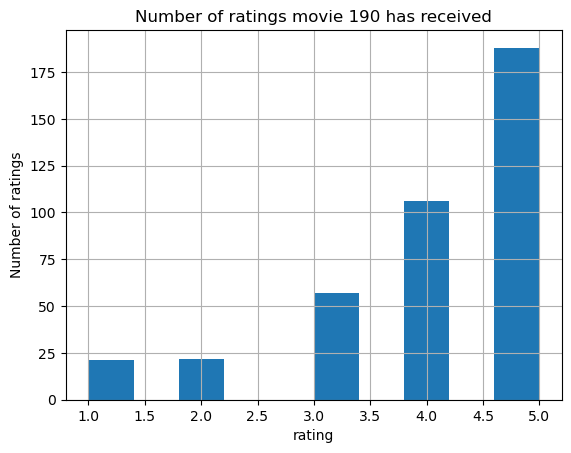

In [179]:
import matplotlib.pyplot as plt
df.loc[df['itemID'] == 56]['rating'].hist()
plt.xlabel('rating')
plt.ylabel('Number of ratings')
plt.title('Number of ratings movie 190 has received')
plt.show()

It seems as if the user, who rated the movie a 1, is a bit of an outlier. With this in mind, it makes sense that our model predicted a score of 5. Let's check the next worst prediction

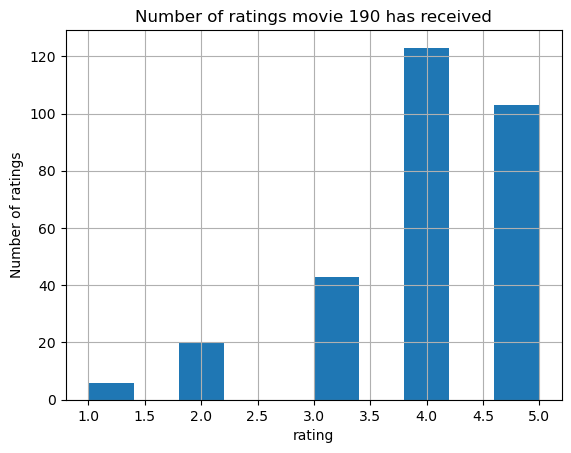

In [180]:
df.loc[df['itemID'] == 96]['rating'].hist()
plt.xlabel('rating')
plt.ylabel('Number of ratings')
plt.title('Number of ratings movie 190 has received')
plt.show()

Once again, it seems as if the user's score is an outlier (most rated it highly, except for user 314, which rated it very low). With these two examples in mind, as well as the model having RMSE of 0.9067, we're content with the result of the model. Now we're ready to recommend some movies!

In [181]:
import difflib
import random

def get_movie_id(movie_title, metadata):
    existing_titles = list(metadata['movie_title'].values)
    closest_titles = difflib.get_close_matches(movie_title, existing_titles)
    movie_id = metadata[metadata['movie_title'] == closest_titles[0]]['movie_id'].values[0]
    return movie_id

def get_movie_info(movie_id, metadata):
    movie_info = metadata[metadata['movie_id'] == movie_id]
    movie_info = movie_info.loc[:, (movie_info != 0).any(axis=0)]
    return movie_info.to_dict(orient='records')[0]

def predict_review(user_id, movie_title, model, metadata):
    
    movie_id = get_movie_id(movie_title, metadata)
    review_prediction = model.predict(uid=user_id, iid=movie_id)
    return review_prediction.est

def generate_recommendation(user_id, model, metadata, thresh=4):
    
    movie_titles = list(metadata['movie_title'].values)
    random.shuffle(movie_titles)
    movie_list = []

    for movie_title in movie_titles:
        rating = predict_review(user_id, movie_title, model, metadata)
        if rating >= thresh:
            movie_id = get_movie_id(movie_title, metadata)
            movie_list.append(get_movie_info(movie_id, metadata))
        if(len(movie_list) == 5):
            return movie_list

recommendation = generate_recommendation(200, algo, movies, thresh=4)
recommendation

[{'movie_id': 68,
  'movie_title': 'Crow, The (1994)',
  'release_date': '01-Jan-1994',
  'Action': 1,
  'Romance': 1,
  'Thriller': 1},
 {'movie_id': 652,
  'movie_title': 'Rosencrantz and Guildenstern Are Dead (1990)',
  'release_date': '01-Jan-1990',
  'Comedy': 1,
  'Drama': 1},
 {'movie_id': 1429,
  'movie_title': 'Sliding Doors (1998)',
  'release_date': '01-Jan-1998',
  'Drama': 1,
  'Romance': 1},
 {'movie_id': 1076,
  'movie_title': 'Pagemaster, The (1994)',
  'release_date': '01-Jan-1994',
  'Action': 1,
  'Adventure': 1,
  'Animation': 1,
  "Children's": 1,
  'Fantasy': 1},
 {'movie_id': 1633,
  'movie_title': 'Á köldum klaka (Cold Fever) (1994)',
  'release_date': '08-Mar-1996',
  'Comedy': 1,
  'Drama': 1}]

Finally, check if these movies are in the same genres as the ones the user usually watches.

In [183]:
user_200_ratings = df[df['userID'] == 200].sort_values(by='rating', ascending=False)
# display(user_200_ratings)
# user_200_ratings_ids = user_200_ratings['itemID']

user_200_movies = movies[movies['movie_id'].isin(user_200_ratings_ids)][:10]
user_200_movies.loc[:, (user_200_movies != 0).any(axis=0)]

,movie_id,movie_title,release_date,Action,Adventure,Animation,Children's,Comedy,Crime,Drama,Sci-Fi,Thriller,War
0,1,Toy Story (1995),01-Jan-1995,0,0,1,1,1,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,1,1,0,0,0,0,0,0,1,0
6,7,Twelve Monkeys (1995),01-Jan-1995,0,0,0,0,0,0,1,1,0,0
7,8,Babe (1995),01-Jan-1995,0,0,0,1,1,0,1,0,0,0
8,9,Dead Man Walking (1995),01-Jan-1995,0,0,0,0,0,0,1,0,0,0
10,11,Seven (Se7en) (1995),01-Jan-1995,0,0,0,0,0,1,0,0,1,0
14,15,Mr. Holland's Opus (1995),29-Jan-1996,0,0,0,0,0,0,1,0,0,0
21,22,Braveheart (1995),16-Feb-1996,1,0,0,0,0,0,1,0,0,1
23,24,Rumble in the Bronx (1995),23-Feb-1996,1,1,0,0,0,1,0,0,0,0
24,25,"Birdcage, The (1996)",08-Mar-1996,0,0,0,0,1,0,0,0,0,0
